# Обучение без учителя

Алгоритмы машинного обучения бывают двух видов: 

* которые требуют размеченной выборки, т.е. у каждого объекта есть "правильный" ответ и задача ML алгоритма научиться восставнавливать эти ответы
* когда размеченной выборки нет и нет "правильных" ответов

Мы изучили алгоритм линейной регрессии - это алгоритм "обучения с учителем", в задаче предсказания цены дома по его параметрам доступно истичнное значение целевой переменной (цены дома).

Однако, истинные ответы не всегда доступны - например, вы хотите разделить пользователей сайта на однородные группы по их поведению. Количество групп, а так же их состав заранее предсказать сложно. Попросить кого-нибудь "разметить" аудиторию крупного ресурса нереально. Что же делать в случае, когда правильные ответы на выборке получить невозможно? Приходится обращаться к алгоритмам обучения "без учителя" (unsupervised)

Мы рассмотрим два семейства таких алгоритмов: кластеризация и снижение размерности.

# Кластеризация

## Задача кластеризации

Кластерный анализ (Data clustering) — задача разбиения заданной выборки объектов на непересекающиеся подмножества (кластеры). Каждый кластер должен состоять из схожих объектов, а объекты разных кластеров должны существенно отличаться. Истинных меток классов алгоритм не требует, но они могут понадобиться на этапе оценки качества

Вот, например, на картинке есть выборка, где у каждого объекта две фичи -  $𝑥_1$  и  $𝑥_2$ . Визуально заметно, что объекты разделяются на три отдельные группы - внутри группы объекты очень похожи, а вот между группами есть отличия. Синим крестиком я отметил центр кластера и добавил отрезки, соединяющие центры кластеров (для наглядности)

![clustering_example](img/clustering_example.png)

Интуитивная постановка задачи кластеризации: у нас есть координаты точек, все точки объединяются в два (или большее количество) кластеров, каждый кластер получает свой номер от $0$ до $N$. Мы хотим построить алгоритм, который
* обработает весь доступный массив точек
* выяснит автоматически количество кластеров
* для каждой новой точки наша модель будет выдавать номер кластера, к которому эта точка относится

Выпишем координаты центра для трёх кластеров с картинки:

* "красный" кластер $c_1 = [1.0, 1.5]$
* "оранжевый" кластер $c_2 = [-1.0, -0.5]$
* "зеленый" кластер $c_3 = [1.0, -0.5]$

Алгоритмы кластеризации основаны на вычислении *"расстояния"* (или *метрики близости*) между точками в датасете для обучения. Для этого в библиотеке `scipy` в модуле `spatial.distance` уже реализовано множество функций для вычисления расстояний - мы воспользуемся функцией [вычисления евклидового расстояния](https://ru.wikipedia.org/wiki/Евклидова_метрика) чтобы посчитать расстояние между двумя точками

In [1]:
from scipy.spatial.distance import euclidean

c1 = [1.0, 1.5]
c2 = [-1.0, -0.5]

dist = euclidean(c1, c2)
print("Расстояние между кластерами c1 и c2: %.4f" % dist)

Расстояние между кластерами c1 и c2: 2.8284


## Алгоритм кластеризации K-средних

Чтобы находить кластера, нужно уметь находить расстояние между точками: точки, которые лежат близко, скорее всего находятся в одном кластере, а вот точки, между которыми расстояние большое, видимо, принадлежат разным кластерам.

Самый простой алгоритм для кластеризации называется "Алгоритм К-средних (K-means)". Буква *K* в названии - это количество кластеров, на которые мы хотим разбить датасет ($K \ge 2$). 

Алгоритм итеративный: на первой итерации центры кластеров  размещаются в случайных местах, а потом сдвигаются таким образом, чтобы попадают в области, где точек больше всего. Визуализация этого алгоритма отображена на gif:

![kmeans8](img/k_means.gif)

Формальное описание алгоритма обучения модели:

1. Выбрать количество кластеров $k$ (тут нужно придумать оптимальное количество, пользуясь эксперитным мнением). Назначить цвет каждому кластеру (на гифке было три кластера).
1. Инициализировать *случайными значениями* координаты кластеров (центроиды)
1. Для каждой точки нашего набора данных посчитать, к какому центроиду она ближе и раскрасить точку в соответствующий цвет
1. Переместить каждый центроид в центр выборки (*среднее* всех элементов, входящих в выборку) соответствующих ему элементов
1. Повторять до выполнения одного из условий
    1. Алгоритм сошелся (положение центроидов не меняется)
    1. Превышено максимально допустимое число итераций
    
Для входной точки $x$ нужно найти, какой кластер к ней ближе всего - туда и стоит отнести нашу точку $x$.

Проиллюстрируем работу алгоритма:

* две фичи $x_1, x_2$
* два класса

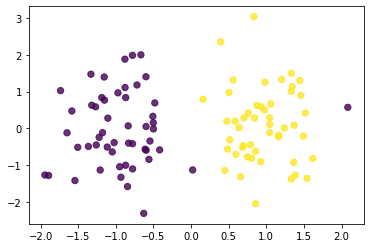

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

with open('data/clustering.pkl', 'rb') as f:
    data_clustering = pickle.load(f)

X = np.array(data_clustering['X'])
Y = np.array(data_clustering['Y'])

plt.scatter(X[:, 0], X[:, 1], s=40, c=Y, marker='o', alpha=0.8, label='data')
plt.show()

Применяем алгоритм кластеризации

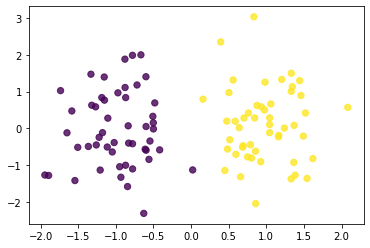

In [3]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=2, random_state=42)
kmeans_model.fit(X)

predicted_labels = kmeans_model.labels_
plt.scatter(X[:, 0], X[:, 1], s=40, c=predicted_labels, marker='o', alpha=0.8, label='data')
plt.show()

Мы в две строчки обучили модель, которая довольно хорошо уловила кластера и правильно проставила метки. При этом мы не давали алгоритму никакой дополнительной информации - единственный параметр, который мы подсказали алгоритму - количество кластеров, на которые нужно разбить датасет.

Алгоритм к-средних очень простой и его легко реализовать, но есть и несколько недостатков:

1. вычислительная сложность - элементов может быть очень много и нахождение расстояний может отнять значительное время. В этом случае применяют вычисление центроидов по подвыборке, такая модификация получила название **mini batch K-mean**

1. где лучше инициализировать центроиды, как задать им начальное положение? От начальной инициализации зависит то, куда сойдётся алгоритм и как быстро он это сделаем. Для решения этой проблемы придумали такую эвристику: давайте запускать алгоритм несколько раз и запоминать, куда попали центроиды. После нескольких запусков есть два варианта: усреднить центроиды или выбрать лучший по метрикам качества

Попробуем реализовать эту эвристику: запустить несколько раз алгоритм, запомнить, куда попали центроиды при каждом запуске, в потом усреднить координаты за все несколько запуска.

Попробуйте применить эту эвристику на практике: 

* используйте 10 запусков алгоритма $k$-средних для $k=2$ с параметрами
<pre>
kmeans_model = KMeans(n_clusters=2, n_init=1, random_state=None, algorithm='full', max_iter=2)
</pre>
* в каждом запуске сохраняйте координаты центроидов общий массив $c$, см. `cluster_centers_ : array, [n_clusters, n_features]`
* визуализируйте координаты точек из $c$ на фоне исходного множества точек

Результат будет примерно такой:
![several_init_knn](img/several_init_knn.png)

In [1]:
# -- ВАШ КОД ТУТ --





# ------------------

## Выбор количества кластеров

Существенный недостаток алгоритма заключается в необходимости до начала эксперимента выбирать количество кластеров. Обычно это число выбирается на основе "экспертных знаний".

К выбору оптимального количества кластеров можно подойти как к задаче оптимизации - выбрать метрику качества кластеризации (внутрикластерное расстояние), которая зависит от параметра $K$ найдём как-нибудь, при каком значении $K$ метрика достигает оптимума.

Чтобы посчитать внутрикластерное расстояние, нужно найти расстояние от каждой точки из массива $X$ до центра кластера, а потом просуммировать эти расстояния.
$$
\sum_{i=1}^{k} \mid x_i - c \mid
$$

где для одного обучающего примера x, состоящего из двух координат:
$$
\mid x - c \mid = (x_1-c_1)^2 + (x_2-c_2)^2
$$



**Самостоятельное задание**: посчитать сумму внутрикластерных расстояний от каждой точки до центроида

In [5]:
import numpy as np

clust = np.array([
 [-0.5972191612445694, -0.5919098916910581],
 [-1.5838020751869848, 0.4743393635868491],
 [-1.892642118066139, -1.2770390481464395],
 [-1.021761443519372, -0.38446059106320013],
 [-0.628271339507516, -2.308149346281125],
 [-0.7180915776856387, 1.1805550909358404],
 [-1.543143767548152, -1.4163791359687334],
 [0.022103701018375554, -1.1279478858865397],
 [-0.7776518874305778, -0.4157532453316538],
 [-1.2073577296008344, -1.1308523658604184]
])

centroid = np.array([-0.9774245525274352, -0.032635425821084516])

# -- ВАШ КОД ТУТ --





# ------------------

Для подбора вводится метрика качества кластеризации с центроидами $\mu_k: \forall k=1,\ldots,K$, которая измеряет внутрикластерное расстояние - насколько хорошо центр, который мы выбрали, совпадает с "идеальным" цетром кластера
$$
J(C) = \sum_{k=1}^{K}\sum_{j \in C_k} \mid x_j - \mu_k \mid \rightarrow min
$$

В этой формуле
* $\mu_k$ - координаты центроида кластера под номером $k$, количество кластеров $k$
* $x_j$ - объект под номером $j$, принадлежащий кластеру под номером $k$
* $\mid x_j - \mu_k \mid$ - евклидово расстояние от примера $x_j$ до центроида $\mu_k$

Очевидно, что эта метрика достигает оптимума в точке, где количество соответствует количеству элементов в выборке. Однако, это вырожденый случай - на практике применяют эвристику "метод локтя": выбирают такое количество кластеров, при котором резко снижается динамика изменения $J(C)$:
$$
D(K) =\frac{\mid J(C_{k+1}) - J(C_{k}) \mid}{\mid J(C_{k}) - J(C_{k-1}) \mid} \rightarrow \min
$$

Пример на картинке:
![elbow_method](img/elbow_method.png)

In [5]:
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import euclidean_distances

metrics = []
MAX_CLUSTERS = 7
for cluster_num in range(1, MAX_CLUSTERS):
    kmeans_model = KMeans(n_clusters=cluster_num, random_state=99).fit(X)
    centroids, labels = kmeans_model.cluster_centers_, kmeans_model.labels_
    metric = 0
    for centroid_label in range(cluster_num):
        # ормула для D(k)
        intra_cluster_distance_sum = euclidean_distances(
            X[labels==centroid_label],
            centroids[centroid_label,:].reshape(1,-1)
        )
        # сумма внутрикластерных расстояний
        metric += intra_cluster_distance_sum.sum(axis=0)[0]
    print("cluster_num %s, metric %s" % (cluster_num, metric))
    metrics.append(metric)

cluster_num 1, metric 135.92762259869988
cluster_num 2, metric 92.34245055263459
cluster_num 3, metric 74.52323397050206
cluster_num 4, metric 60.75176580321338
cluster_num 5, metric 54.86662031054898
cluster_num 6, metric 49.745770433790256


Визуализируем зависимость метрики от количества кластеров на графике

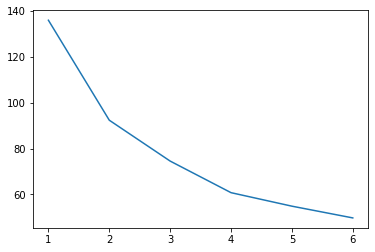

best cluster num: 2


In [6]:
D = []
for i in range(0, len(metrics)-1):
    d = (
        abs(
            metrics[i+1]-metrics[i]
        ) / abs(
            metrics[i]-metrics[i-1]
        )
    )
    D.append(d)

plt.plot(
    [
        i+1 for i in range(len(metrics))
    ],
    metrics
)
plt.show()
print("best cluster num: %s" % (np.argmin(D)+1))

Визуально заметно, что в точке $k=2$ в графике наблюдается перегиб - это и есть тот самый "локоть". Значит, оптимальное количество кластеров для нашего датасета $k=2$.

## Реализация алгоритма K-средних на python

Давайте создадим свою реализацию алгоритма на питоне, чтобы лучше понимать, как он работает.

шаг 0, смещение кластеров: [0.20968291868585037, 0.6289089155226919]
шаг 1, смещение кластеров: [0.11491039409728283, 0.15757514787937224]
шаг 2, смещение кластеров: [0.2443496760067584, 0.22851196190566744]
шаг 3, смещение кластеров: [0.22334876253680938, 0.22014171305624555]
шаг 4, смещение кластеров: [0.06666926746122605, 0.066669267461226]
шаг 5, смещение кластеров: [0.0, 0.0]


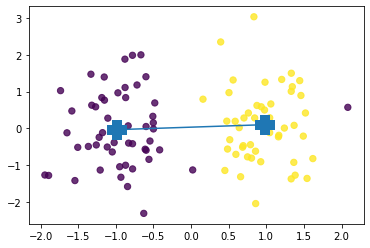

In [9]:
import numpy as np
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib import pyplot as plt

%matplotlib inline

def random_centroids_selection(X, n, k):
    """Рандомно инициализируем центр кластера"""
    result = []
    for obj_id in np.random.randint(0, n, size=k):
        result.append(X[obj_id, :])
    return result

def eval_weight_evolution(centroid_objects_prev, centroid_objects, k):
    """Вычисляем, как сдвинулись центры за один шаг алгоритма"""
    result = []
    for i in range(k):
        dist = distance.euclidean(
            centroid_objects_prev[i],
            centroid_objects[i]
        )
        result.append(dist)
    return result

def eval_centroids(X, k, cluster_lables):
    """Вычисляем новые центроиды с методом усреднения координат"""
    result = []
    for i in range(k):
        new_centroid = X[cluster_lables==i].mean(axis=0)
        result.append(new_centroid)
    return result

def eval_cluster_lables(X, centroid_objects):
    """Вычисляем метки кластеров"""
    # формируем матрицу (n x k), которая содержит расстояние от каждого объекта до каждого центроида
    cluster_distance = euclidean_distances(X, centroid_objects)
    # находим минимальное расстояние в каждой строчке - это будет кластер объекта
    cluster_lables = cluster_distance.argmin(axis=1)
    return cluster_lables

def k_means(X:np.array, k: int=2, eps: float=0.001, num_iteration: int=10) -> np.array:
    """Алгоритм К-средних
    
    :param X: обучающая выборка
    :param k: количество кластеров
    """
    try:
        n, m = X.shape
    except ValueError:
        print("Обучающая выборка должна быть двумерным массивом (n, m) гдк m - размер выборки")
    # инициализируем центроиды случайным элементом выборки
    centroid_objects = random_centroids_selection(X, n, k)
    centroid_objects_prev = [np.zeros(m) for i in range(k)]
    # расстояние между предыдущим и текущим положением каждого центроида
    weight_evolution = eval_weight_evolution(centroid_objects_prev, centroid_objects, k)
    step = 0
    # условие остановки: центроиды не изменили своего положения
    # повторяем до выполнения условия остановки
    while sum(weight_evolution[i] > eps for i in range(k))!=0 and step < num_iteration:
        # иначе можно прострелить себе ногу =0
        centroid_objects_prev = centroid_objects.copy()
        # вычисляем метки кластеров
        cluster_lables = eval_cluster_lables(X, centroid_objects)
        # усредняем координаты объектов каждого кластера - это новое положение центроида
        centroid_objects = eval_centroids(X, k, cluster_lables)
        # вычисляем расстояние между центроидами на соседних итерациях
        weight_evolution = eval_weight_evolution(centroid_objects_prev, centroid_objects, k)
        print("шаг %s, смещение кластеров: %s" % (step, weight_evolution))
        # обновлённые кластера
        step += 1
    return np.vstack(centroid_objects), cluster_lables
    

centroids, labels = k_means(X, k=2, num_iteration=10)

plt.scatter(X[:, 0], X[:, 1], s=40, c=Y, marker='o', alpha=0.8, label='data')
plt.plot(centroids[:, 0], centroids[:, 1], marker='+', mew=10, ms=20)
plt.show()

## Алгоритм DBSCAN

Алгоритм k-средних хорошо справляется с задачей кластеризации в случае, когда кластеры *линейно разделимы* и представляют собой отдельные скопления точек.

Однако, часто никаких отдельных множеств нет и кластеры плавно переходят друг в друга, но при этом хорошо видны области, где плотность точек (количество на единицу площади) больше, чем в других областях. В таком случае хорошо справляются алгоритмы,основанные на анализе плотности точек - например, алгоритмы DBSCAN.

DBSCAN (Density-based spatial clustering of applications with noise, плотностной алгоритм пространственной кластеризации с присутствием шума) принимает на вход два параметра

* $\varepsilon$ - радиус окрестности, в котором мы ищем соседей каждой точки
* пороговое значение $k$ количества соседей внутри радиуса $\varepsilon$

Оба этих параметра подбираются на валидационной выборке с помощью процедуры GridSearch, с которой вы познакомились в уроке про линейную регрессию.

Как  будет работать этот алгоритм? В первом приближении можно сказать, что мы будем ориентироваться на плотность точек: если в какой-то точке пространства точки лежа очень "густо" - там скорее всего, кластер. Если густота точек снижается, то мы, видимо, попали на границу кластера. А вот если у точки совсем нет соседей - наверное, это какой-то выброс и такая точка вообще ни в один кластер не входит.

Алгоритм построения кластеров
следующий

1. Строим окрестность радиуса $\varepsilon$ вокруг каждой точки датасета и присваиваем каждой точке целое число $m$ - число соседей этой точки, которые попали в окрестность
1. Всем точкам, у которых $m \ge k$, то есть число соседей не меньше порогового значения, мы присваиваем флаг `core_element` - такие точки являются "опорными", они находятся внутри кластера
1. Рассмотрим все точки, которые не являются опорными. Если среди соседей внутри $\varepsilon$-окрестности точки есть опорная, то такую точку назовём `border_element`, граничным элементом. Граничные элементы нам не очень интересны, нам важны только те точки, которые однозначно попадают в какой-либо кластер.
1. Остались точки, у которых мало соседей в окрестности и среди тех соседей, которые есть, отсутствуют "опорные" элементы. Пометим такие точки флагом `outlier` - это выбросы, они ни к какому кластеру не относятся
1. Сформируем кластеры: два элемента можно объединить в кластер, когда между ними можно построить цепочку из опорных элементов

При таком походе в кластеры объединятся все опорные элементы, а граничные элементы будут отделять кластеры друг от друга.

![dbscan.img](img/dbscan.png)

Такая схема алгоритма проста для понимания, но сложна в реализации. На практике кластеры  будут формироваться итеративно:

1. Берём случайную точку из датасета. Если меньше $k$ соседей в окрестности, то помечаем её как возможный `outlier` 
1. Добавляем её в список опорных элементов, если это возмжно, исключаем из списка точек, которые надо обойти
    1. Создаём новый кластер, в который добавляем эту точку - например, в виде массива с порядковыми номерами элементов из исходного датасета
    1. Обходим всех соседей этой "опорной" точки. Если сосед уже в списке потенциальных `outliers` или у него меньше $k$ соседей в окрестности, то помечаем эту точку как `border`. Иначе новая точка присоединяется к тому же кластеру, что и текущая.
1. Повторяем шаги, пока в датасете не исчерпаются данные

После окончания работы алгоритма у нас все точки окажутся раздёлёнными на три части: опорные, граничные, и выбросы.

Реализация алгоритма есть в sklearn

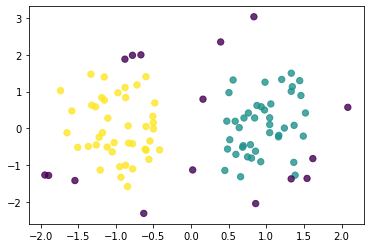

In [10]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.6, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

labels = db.labels_

plt.scatter(X[:, 0], X[:, 1], s=40, c=labels, marker='o', alpha=0.8, label='data')
plt.show()

Обучите модель DBSCAN с параметром min_samples=8. Визуализируйте результат.

In [13]:
# ---- ВАШ КОД ТУТ -----



# ----------------------

## Метрики качества кластеризации

Задача оценки качества кластеризации является более сложной по сравнению с оценкой качества классификации. Нам неизвестны "истинные" метки объектов, поэтому нужны такие метрики качества, которые можно вычисить по неразмеченной выборке.

### Коэффициент Силуэтта 

К-т Силуэтта (англ *Silhouette*) - это метрика, которая не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации.

Интуитивное описание метрики:
* точки внутри кластера должны лежать очень близко друг к другу, то есть кластер должен быть *плотным*
* сами кластера должны лежать как можно дальше друг от друга

Метрика силуэта позволяет учитывать оба этих факта в одной формуле.

Чтобы вычислить его для каждого объекта нужно вычислить для каждого объекта выборки две величины, $a$ (среднее расстояние от данного объекта до объектов из того же кластера) и $b$ (среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). 

Силуэтом объекта назовём нормализованную разность между этими величинами

$$
s = \frac{b-a}{\max(a,b)}
$$

Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Эта величина меняется в интервале от $-1$ до $1$:

* -1 значит что кластера плохие, размытые
* 0 значит что кластера накладываются друг на друга
* 1 значит что кластера плотные и хорошо отделены друг от друга

Таким образом, чем ближе значение к-та Силуэтта в единице, тем лучше. Все, что больше $0.5$ хорошие значения, всё что меньше - надо улучшать.

Формулу реализовывать не надо, она уже есть в *sklearn*:

In [12]:
from sklearn.metrics import silhouette_score

model = KMeans(n_clusters=2).fit(X)

score = silhouette_score(X, model.labels_)

print("Качество кластеризации по метрице силуэтта %.3f" % score)

Качество кластеризации по метрице силуэтта 0.447


Таким образом мы вычислили качество нашей кластеризации - например, мы можем выбрать с помощью этой метрики количество кластеров. Как узнать, сколько кластеров лучше - два или три? Давайте посчитаем  метрику силуэта для случая трех кластеров

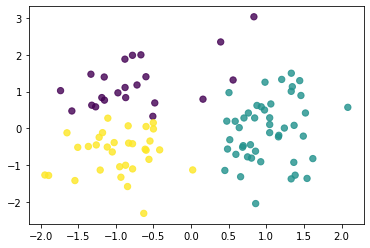

Качество кластеризации по метрике силуэтта  для трёх кластеров 0.452


In [13]:
model = KMeans(n_clusters=3).fit(X)

score = silhouette_score(X, model.labels_)

plt.scatter(X[:, 0], X[:, 1], s=40, c=model.labels_, marker='o', alpha=0.8)
plt.show()

print("Качество кластеризации по метрике силуэтта  для трёх кластеров %.3f" % score)

Целевая метрика увеличилась - значит, три кластера лучше чем два! Визуально кажется, что два кластера лучше, но метрика показывает обратное - так получилось из-за того, что в кластерах множество выбросов и простой алгоритм K-Means не может выделить правильные кластеры. Косвенно это значит, что алгоритм не подходит для решения нашей задачи. В реальных задачах нужно доверять метрике, а не собственным глазам.

### Adjusted Mutual Information

Мы знаем, что в задаче кластеризации можно использовать метрику "коэффициент Силуэтта". Это очень удобно и идеально подходит для случаев, когда выборку невозможно разметить - например, из-за большого объёма. 

Иногда в задаче кластеризации мы всё-таки знаем "правильные" метки кластеров - например, для разметки можно привлечь помощников. Если "истинная" метка кластера нам известна, то можно применять такую метрику как скорректированная взаимная информация (Adjusted Mutual Information).

По сути эта метрика сравнивает два вероятностных распределения меток кластеров - истинное распределение и то, которое получили в результате кластеризации, про эту метрику есть подробная статья на [википедии](https://en.wikipedia.org/wiki/Adjusted_mutual_information).

In [18]:
from sklearn.metrics.cluster import adjusted_mutual_info_score

model = KMeans(n_clusters=3).fit(X)
score = adjusted_mutual_info_score(Y, model.labels_, average_method='arithmetic')

print("Качество кластеризации по метрике AMI %.3f" % score)

Качество кластеризации по метрике AMI 0.614


Что делать в реальной задаче, как выбрать правильную метрику? Считаем все и выбираем, какая из них коррелирует с онлайном.

### Домашнее задание 

Обучите *k-means* из модуля sklearn для количества кластеров $k=4$ на датасете `data/clustering.pkl`. Как изменилась метрика силуэтта? Стало лучше или хуже? Какое количество кластеров лучше, два или четыре?

Обучите *k-means* для количества кластеров $k=4$ на датасете `data/clustering.pkl`. Как изменилась метрика *AMI*? Стало лучше или хуже? Какое количество кластеров лучше мо метрике AMI?

In [3]:
import pickle

with open('data/clustering.pkl', 'rb') as f:
    data = pickle.load(f)

data.keys()

# ---- ВАШ КОД ТУТ -----



# ----------------------

dict_keys(['X', 'Y'])

Мы познакомились с двумя метриками кластеризации

* Silhouette. Её используем, когда есть только сами объекты, а метки кластеров отсутствуют в обучающей выборке
* AMI. Её используем, когда известны "истинные" метки кластеров

Метрик намного больше - о них можно почитать [ в документации sklearn](https://scikit-learn.org/stable/modules/classes.html#clustering-metrics)

# Снижение размерности

Ещё один вид алгоритмов unsupervised machine learning

## Постановка задачи понижения размерности

Алгоритмы машинного обучения работают с выборками, в которых могут быть десятки и даже сотни признаков. Однако, не все признаки могут быть одинаково полезны. Например, если мы занимается задачей прогнозирования времени нерdного срыва, то некоторые фичи у нас будут независимы друг от друга (например, "угрюмость" настроения и артериальное давление), в то время как другие переменные будут связаны друг с другом т.е. зависимы: например, на картинке мы видим, что фича *угрюмость настроения* зависит линейно от фичи *количество часов сна* - очевидно, что чем меньше человек спит, тем больше угрюмость.

![sleepy_mood](img/sleepy_mood.png)

Интуитивно кажется, что из двух зависимых переменных можно оставить одну, т.к. в данном случае "связанные" переменные не добавляют качественно новой информации - мы можем в модели использовать только количество часов сна, потому что "угрюмость" всё равно связана с этой фичёй. 

Так возникает задача снижения размерности - хотим заменить несколько таких "связанные" фичей на одну. Без потери качества.

Карлом Пирсоном в 1901 был придуман Principal Component Analysis, или метод главных компонент. Пирсон решал задачу апроксимации (приближения) экспериментальных данных линейными преобразованиями, т.е. прямыми. Пирсон пытался перейти от двумерной задачи к одномерной. Ниже картинка из оригинальной работы, на которой демонстрируется главная компонента, которая представляет собой прямую линию

![главная компонента](img/pearson_corr.jpg)

**Метод PCA** ( principal component analysis) позволяет снизить число переменных, выбрав самые изменчивые из них . Интуиция тут такая: чем сильнее изменяется переменная (чем больше у неё дисперсия, такую переменную называют "вариативной") - тем больше она содержит информации. *Главные компоненты* - это новые переменные, которые представляют собой линейные преобразования от исходных фичей. Например, на картинке с предыдущего слайда есть прямая и вдоль этой прямой данные изменяются *сильнее всего*.

Например, есть переменные $x_1$ и $x_2$. Главные компоненты - это просто преобразования исходных координат. Выглядеть они могут, например так (**сильно вникать не нужно, это всего лишь пример**):
$$
\left\{
\begin{array}{c}
p_1 = \frac{1}{\sqrt{2}}x_1 + \frac{1}{\sqrt{2}}x_2 \\
p_2 = -\frac{1}{2}x_1 - \frac{\sqrt{3}}{2}x_2
\end{array}
\right.
$$

Что делать после того, как мы нашли главные компоненты (по каким правилам их находить, мы узнаем позже)? Мы знаем, что чем меньше номер у главной компоненты, тем больше дисперсии в данных она "объясняет". Значит, мы можем откинуть компоненту $p_2$ и оставить только главную компоненту $p_1$, то есть свести описание данных от двух переменных $x_1, x_2$ к одномерному случаюи описать данные переменной $p_1$:
$$
p_1 = \frac{1}{\sqrt{2}}x_1 + \frac{1}{\sqrt{2}}x_2
$$

## Применение PCA для снижения размерности.


В sklearn реализован алгоритм PCA. Загрузим датасет для экспериментов:

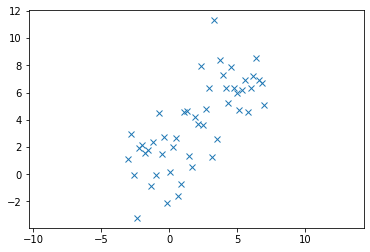

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

with open('./data/eigen.pkl', 'rb') as f:
    X = pickle.load(f)

plt.plot(X[:,0], X[:,1], 'x')
plt.axis('equal')
plt.show()

Применяем алгоритм `sklearn.decomposition.PCA` к набору данных:

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1).fit(X)
X_pca = pca.transform(X)
X_pca[:10]

array([[5.28331909],
       [3.84284422],
       [5.88859559],
       [8.07409089],
       [4.16799935],
       [3.8592636 ],
       [4.17040423],
       [3.86884344],
       [5.65483844],
       [3.16278418]])

Мы сжали с помощью PCA двумерные данные в одномерный массив. 

![pca_arrays](img/pca_arrays.png)

Давайте визуализируем этот массив - для этого надо произвести обратное преобразование из одномерного массива в двумерный. Отобразим "восстановленные" данные на графике (вторая картинка - исходный, не сжатый массив):

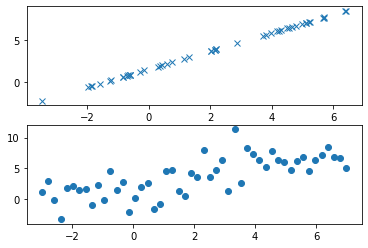

In [25]:
X_new = pca.inverse_transform(X_pca)

plt.figure(1)
plt.subplot(211)
plt.plot(X_new[:,0], X_new[:,1], 'x')

plt.subplot(212)
plt.plot(X[:,0], X[:,1], 'o')
plt.show()

Алгоритм PCA выявил, что переменная от $x_2$ линейным образом зависит от переменной $x_1$ - то есть вместо перемнной $x_2$ можно использовать линейное преобразование $x_2 = x_1w_1 + w_0$ (эта переменная на первом графике). "Сжатые данные" представляют собой график линейной функции $x_2 = ax_1 + b$. 

Данные, представляли собой облако точек, но алгорим PCA ужал их до одномерного случая. Другие интересные визуализации можно [глянуть по ссылке](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)

### Домашнее задание по PCA

В домашней работе предлагается применить PCA трехмерным данным по оттоку, которые содержатся в файле `data/client_segmentation.csv`. В файле содержится информация по клиентам оператора связи о том, как изменилось потребление услуг оператора за два месяца:
* call_diff доля звонков
* sms_diff доля смс
* доля интернет-трафика traffic_diff'


Все показатели вычисляются по формуле

$$
\frac{\text{new_value}-\text{old_value}}{\text{old_value}}
$$

В последней колонке customes_class содержится метка по оттоку:
* $0$ - активный пользователя
* $1$ - "спящий" пользователь (редко пользуется услугами)
* $2$ - пользователь, который ушел в отток

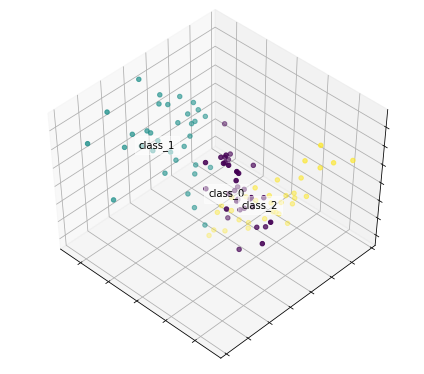

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

df_source = pd.read_csv('data/client_segmentation.csv')
X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values
# и визуализируем их
fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134); plt.cla()
num_labels = np.unique(y).size
for name, label in [('class_%d' % i, i) for i in range(num_labels)]:
    ax.text3D(X[y == label, 0].mean(), X[y == label, 1].mean() + 0.5,
        X[y == label, 2].mean(), name, horizontalalignment='center',
        bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
ax.w_xaxis.set_ticklabels([]); ax.w_yaxis.set_ticklabels([]); ax.w_zaxis.set_ticklabels([])
plt.show()

С помощью класса `sklearn.decomposition.PCA` выполните понижение размерности признакового пространства  с $n=3$ до $n=2$ и снова визуализируйте данные. Картинка должна получится примерно такая:
![classification_dim_reduction](img/classification_dim_reduction.png)

In [27]:
# -- ВАШ КОД ТУТ --




# -----------------

## Продвинутый уровень: реализация алгоритма PCA

Вычисление главных компонент сводится к вычислению собственных векторов и собственных значений ковариационной матрицы исходных данных. Чтобы реализовать этот алгоритм, введём понятие ковариации.

Ковариация признаков $X_i$ и $X_j$:

$$
cov(X_i, X_j) = E[(X_i-\mu_i)(X_j-\mu_j)] = E[X_iX_j] - \mu_i\mu_j
$$

На диагонали этой матрицы стоят дисперсии признаков, т.к. $cov[X_iX_i] = D[X_i]$.

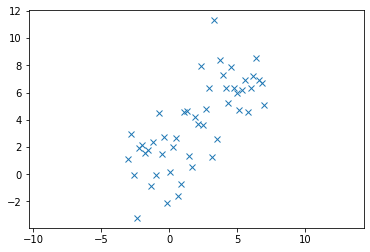

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

with open('./data/eigen.pkl', 'rb') as f:
    X = pickle.load(f)
    
plt.plot(X[:,0], X[:,1], 'x')
plt.axis('equal')
plt.show()

Мы получили две фичи $x_1$ и $x_2$, которые сильно коррелируют друг с другом (потому что мы их специально сгенерировали таким образом). Объединим их в уже известную нам матрицу *объекты-признаки* наблюдений размеров $N \times 2$.

Формула ковариации подсказывает, что для упрощения вычислений данные предварительно нужно центрировать, то есть вычесть из каждого столбца матрицы наблюдений среднее. На графике видно, что данные при этом не изменили свою форму, зато немного "съехали" в сторону начала координат.

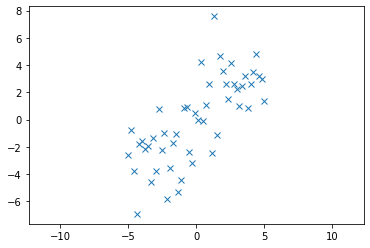

In [17]:
# Центрируем координаты
mean_val = X.mean(axis=0)
N = X.shape[0]
X_centered = X.copy() - mean_val

plt.plot(X_centered[:,0], X_centered[:,1], 'x')
plt.axis('equal')
plt.show()

Выборочная ковариация вычисляется как сумма квадратичных отклонений:
$$
\left\{
\begin{array}{c}
cov(X_i, X_i) = Var(X_i) = \frac{\sum_{i=1}^{N}\left(x_i - \overline{x_i}\right)^2}{n-1}\\
cov(X_i, X_j) = \frac{\sum_{i=1}^{N}\left(x_i - \overline{x_i}\right)\left(x_j - \overline{x_j}\right)}{n-1}
\end{array}
\right.
$$

В нашем случае данные центрированы, то есть отклонение от точки совпадает с значением этой точки, то есть ковариационную матрицу можно вычислить просто с помощью матричного умножения (неплохой пример с этими формулами можно [найти тут](https://towardsdatascience.com/let-us-understand-the-correlation-matrix-and-covariance-matrix-d42e6b643c22)):

In [18]:
# вычисляем ковариационную матрицу "по определению"
X_cov = X_centered.T.dot(
    X_centered
) / (N-1)
print(f"Ковариационная матрица:\n{X_cov}\n")
# готовая реализация из numpy
print(f"Ковариационная матрица из numpy:\n{np.cov(X_centered, rowvar=0)}\n")

Ковариационная матрица:
[[8.85047897 6.81117445]
 [6.81117445 9.95969352]]

Ковариационная матрица из numpy:
[[8.85047897 6.81117445]
 [6.81117445 9.95969352]]



Вычисленная "по определению" матрица ковариации совпадает с реализацией из numpy - мы на правильном пути! Кстати, можно заметить что матрица является симметричной, а так же что все её элементы - положительные числа.

В линейной алгебре существует концепция "собственных векторов"(eigenvectors) и "собственных чисел"(igenvalues). Если по-простому, то у матрицы $A$ существует собственный вектор $w_i$ и собственное число $\lambda_i$, если выполняется соотношение
$$
Aw_i = \lambda_iw_i
$$



Есть несколько особенностей: СВ и СЗ существуют только у квадратных матриц, причём количество собственных значений соответствует размерности матрицы $n$.

Итак, мы хотим найти такие векторы (те самые главные компоненты), при проекции (то есть умножении) на которые наши данные сохранят максимальную долю своей дисперсии. Эти векторы являются просто собственными векторами ковариационной матрицы! Мы используем это утверждение как факт, а математическим обоснованием этого факта является [соотношение Релея](https://ru.wikipedia.org/wiki/Отношение_Рэлея)

В `numpy` есть функция для вычисления СВ, СЗ (которая является обёрткой над системным пакетом [LAPACK](https://ru.wikipedia.org/wiki/LAPACK ))

In [20]:
from numpy import linalg

eigenvalues, eigenvectors = linalg.eig(X_cov)

print(''.join(
    'lambda_{} ={}, w = {}\n'.format(eig_id,eigenvalues[eig_id], eigenvectors[:,eig_id]) 
    for eig_id in range(eigenvalues.size))
)

origin = X_centered.mean(axis=0) # начало координат

lambda_0 =2.57136935073713, w = [-0.7352406   0.67780621]
lambda_1 =16.238803136510406, w = [-0.67780621 -0.7352406 ]



Визуализация

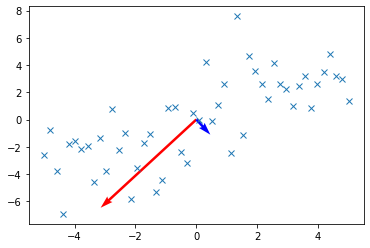

In [21]:
# транспонируем матрицу собственных векторов, чтобы собственный вектор соответствовал строке
plt.quiver(
    *origin,
    *eigenvectors.T,
    color=['r','b','g'],
    scale=eigenvalues
)

plt.plot(X_centered[:,0], X_centered[:,1], 'x')
plt.show()

У нас два признака, которым  соответствуют два собственных вектора. Выберем собственный вектор, который соответствует максимальному собственному значению и умножим на него нашу матрицу наблюдений. То есть у нас были двумерные данные, а мы перешли к одномерным

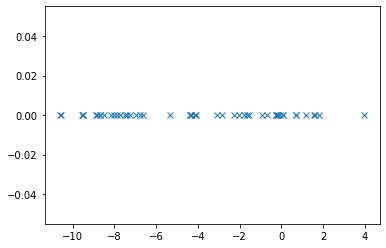

In [34]:
# первой главной компоненте соответствует самое больше собственное значение
max_eigenval = np.argmax(eigenvalues)
# главная компонента, соответствуюющая первому собственному значению
max_eigenvec = eigenvectors[:,max_eigenval].reshape(-1,1)

# X_redused = X.dot(max_eigenvec.reshape(1,-1).T)
X_redused = X.dot(max_eigenvec)

plt.plot(X_redused, np.zeros(N), 'x')
plt.show()

Произведём обратное преобразование - перейдем от одномерного случая к двумерному

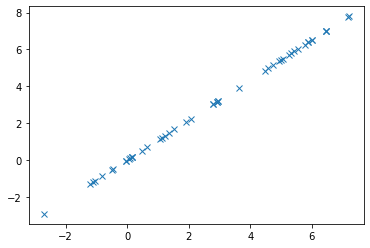

In [35]:
X_inverse = X_redused.dot(max_eigenvec.reshape(1,-1))

plt.plot(X_inverse[:,0], X_inverse[:,1], 'x')

plt.show()

Мы спроецировали наши данные из двумерного пространства в одномерное - из плоскости на линию -  с помощью алгоритма PCA. Видно, что проекция сохраняет в каком-то виде структуру данных (сгущения данных, например, становятся более отчётливо видны).

Понижение размерности применяется для:

* визуализация многомерных данных на плоскости
* подготовка данных для алгоритмов более высокого уровня

Свойства главных компонент:

* каждая главная компонента имеет максимально возможную дисперсию.  Все главные компоненты пронумерованы, с ростом номера главной компоненты уменьшается и доля дисперсии, которую "объясняет" эта компонента
* Корреляция между двумя любыми компонентами равна нулю (т.е. они некоррелированы)

Подводный камень PCA: плохо работает, когда переменные в разных масштабах, например: количество минут пользователя на сервисе (live time) и цена, которую он платит за подписку - цена намного меньше по абсолютным значением, чем количество минут. Выход: выполнять *Z-преобразование* переменных, с которым мы познакомились в уроке про линейную регрессию.

Некоторые исследователи пытаются применять PCA-транформацию данных перед обучением линейной регрессии - это работает плохо, потому что самая вариативная переменная может быть слабо связана с целевой переменной.

# SVD преобразование

SVD (Singular Value Decompozition) - это метод, который пришёл в машинное обучение из линейной алгебры. Этот метод применяется для снижения размерности так же, как PCA.

Суть метода состоит в том, что любую прямоугольную матрицу $X$ (у нас это матрица объекты-признаки) размерности $m\times n$ можно представить в виде произведения трёх матриц разной размерности (двух квадратных и прямоугольной в середине):
$$
X = USV^T
$$

где 

* $U$ размерности $m\times m$
* $S$ размерности $m\times n$, диагональная матрица, на диагонали стоят собственные числа матрицы $X^TX$ (мы говорили о них у уроке 3)
* $V$ размерности $n\times n$

Такое разложение одной матрицы на три [называется сингулярным](http://www.machinelearning.ru/wiki/index.php?title=Сингулярное_разложение ). Этот метод реализован в библиотеке *numpy*, применить его нужно будет в рамкаж домашнего задания

Зачем же нужно сингулярное преобразование и как применить его к задаче снижения размерности? Мы уже говорили, что матрица $S$, в центре разложения, является диагональной:

$$
S = 
\left[
\begin{array}{cccccc}
\sigma_1 & 0 & 0 & \ldots & 0 & 0 \\
0 & \sigma_2 & 0 &  \ldots & 0 & 0 \\
0 & 0 & \sigma_3 & \ldots & 0 & 0 \\
\ldots& \ldots& \ldots& \ldots& \ldots & \ldots\\
0 & 0 & \ldots & 0 & 0 & 0 \\
0 & 0 & \ldots & 0 & 0 & 0 \\
\end{array}
\right]
$$

Числа  $\sigma_1, \sigma_2, \ldots \sigma_n$ на главной диагонали расположены по возрастанию. Суть SVD состоит в том, что для снижения размерности мы можем оставить как есть числа $\sigma_1, \sigma_2, \ldots, \sigma_k$ до некоторого $k<m$ и приравнять к нулю $\sigma_{k+1}, \sigma_{k+2},\ldots, \sigma_n$

Логика обнуления диагональных элементов реализована в классе [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html). Давайте применим его для снижения размерности, как мы применяли PCA во втором уроке этого модуля

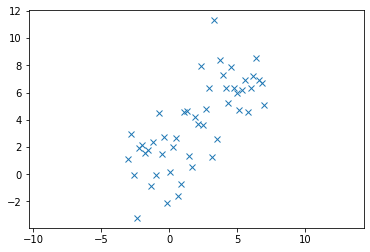

In [22]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

with open('./data/eigen.pkl', 'rb') as f:
    X = pickle.load(f)
    
plt.plot(X[:,0], X[:,1], 'x')
plt.axis('equal')
plt.show()

Понизим размерность с помощью SVD

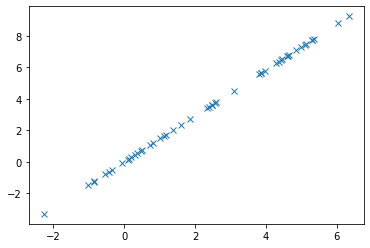

In [23]:
# получаем SVD разложение
svd_model = TruncatedSVD(n_components=1).fit(X)
# применяем преобразование к исходным данным
X_svd = svd_model.transform(X)
# трансформируем данные обратно к исходному пространству
X_svd_restored = svd_model.inverse_transform(X_svd)
# визуализируем то, что получилось
plt.plot(X_svd_restored[:,0], X_svd_restored[:,1], 'x')
plt.show()

Готово! Мы воспользовались алгоритмом снижения размерности TruncatedSVD и получили картинку, похожую на результат применения алгоритма PCA. Оба этих метода сильно похожи, про связь PCA и SVD можно [почитать тут](https://towardsdatascience.com/pca-and-svd-explained-with-numpy-5d13b0d2a4d8) [или тут](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca/134283). Как понять какой из них выбрать для решения задачи?

* если нужно быстро снизить количество фичей - используйте SVD
* если дополнительно нужно избавиться от корреляции между фичами (например, для задачи линейной регрессии) - используйте PCA

### Домашнее задание


В домашней работе предлагаю Вам немного поработать с изображениями (похожий трюк можно увидеть в этой [статье на хабре](https://habr.com/ru/post/275273/)). Для этого нужно установить модуль Pillow (если у вас Анаконда, то https://anaconda.org/anaconda/pillow)

<pre>
pip install Pillow
</pre>

Загрузим картинку в трёхмерный *numpy array* и отобразим её прямо jupyter notebook.

<class 'numpy.ndarray'> (202, 310, 3)


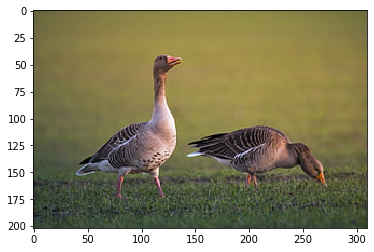

In [24]:
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
img = mpimg.imread('img/gray_goose.jpg')
print(type(img),img.shape)
imshow(img)
plt.show()

У нас трёхмерный массив, где третье измерение соответствует цветовой компоненте rgb. Цветную картинку можно преобразовать в двумерную серую (grayscale) с помощью формулы, которую я нашёл [тут](https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python) 

<class 'numpy.ndarray'> (202, 310)


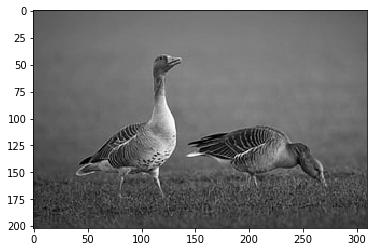

In [25]:
def rgb2gray(rgb):
    tile = np.tile(np.c_[0.333, 0.333, 0.333], reps=(rgb.shape[0],rgb.shape[1],1))
    return np.sum(tile * rgb, axis=2)

img_gray = rgb2gray(img)
print(type(img_gray), img_gray.shape)
imshow(img_gray, cmap = "gray")
plt.show()

Далее 

* обучите на массиве *img_gray* размерности $202 \times 310$ класс TruncatedSVD c параметром n_components=5
* получите матрицу *img_gray_svd* с помощью функции `transform`
* получите массив *img_gray_svd_restored* с помощью функции `inverse_transform`
* визуализируйте массив *img_gray_svd_restored* с помощью функции *imshow*

Этот алгоритм демонстрирует, как происходит сжатие данных большой размерности. А результате у вас должен получиться гусь как бы в очень нечётком виде


In [42]:
# -- ВАШ КОД ТУТ --




# -----------------

## Трансформация t-SNE

Есть [подробная статья на хабре](https://habr.com/ru/post/267041/).

Алгорим нужен, когда PCA плохо работает. Мы знаем, что алгоритм PCA (или SVD) хорошо сжимает данные, в которых наблюдается линейная зависимость. Но часто данные больших размерностей содержат сложные нелинейные преобразования. Давай посмотрим, как работает t-sne из коробки на датасете по сегментации клиентов из домашней работы

In [26]:
df_source = pd.read_csv('data/client_segmentation.csv')
X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values

df_source.head()

,call_diff,sms_diff,traffic_diff,customes_class
0,-0.666421,0.444911,-0.273538,0.0
1,-0.889273,-0.537896,-1.959469,2.0
2,-0.841503,0.846665,0.727606,0.0
3,1.389749,0.390911,1.789246,1.0
4,-1.228211,-1.375899,-1.434209,2.0


Выполним сжатие жанных, пользуясь реализацией `sklearn.manifold.TSNE`:

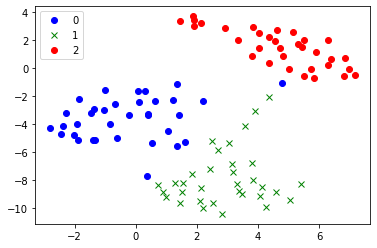

In [27]:
from sklearn.manifold import TSNE

tsne_transformer = TSNE(n_components=2)

x_tsne = tsne_transformer.fit_transform(X)

colors = ['bo', 'gx', 'ro']
# И нарисуем получившиеся точки в нашем новом пространстве
for name, label, color in [('class_%d' % i, i, colors[i]) for i in range(num_labels)]:
    plt.plot(x_tsne[y == label, 0], x_tsne[y == label, 1], color, label=label)
plt.legend(loc=0);

Готово! Визуально данные стали более разделимы, чем  в домашней работе про PCA

Давайте проверим, как t-sne может улучшить Ваши модели. Для начала загрузим данные и построим Baseline модель без преобразования входных данных

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

def eval_model(input_x, input_y):
    """Обучаем и валидируем модель"""
    X_train, X_test, y_train, y_test = train_test_split(
        input_x, input_y, test_size=.3, stratify=y, random_state=42
    )
    # Для примера возьмём неглубокое дерево решений
    clf = DecisionTreeClassifier(max_depth=2, random_state=42)
    clf.fit(X_train, y_train)
    preds = clf.predict_proba(X_test)
    acc_score = accuracy_score(y_test, preds.argmax(axis=1))
    print('Accuracy: %.5f' % acc_score)

X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values

Вычисляем скор baseline модели (по тестовым данным)

In [29]:
eval_model(X, y)

Accuracy: 0.80000


**Домашнее задание на применение t-sne**

Алгоритм выполнения домашней работы:

* выполните PCA преобразование матрицы $X$, передайте новую матрицу в `eval_model`. Какое значение Accuracy получили?
* выполните t-sne преобразование матрицы $X$, передайте новую матрицу в `eval_model`. Какое значение Accuracy получили?

Какие выводы можно сделать?

In [4]:
# -- ВАШ КОД ТУТ --




# -----------------